In [1]:
"""

EMNIST Classification - Robert MacWha, 2021/05/08

Convolutional EMNIST classification of 28x28x1 images sourced from https://www.kaggle.com/crawford/emnist.  The dataset contains 47 (9 numeric + 38 aphabetic) unique classes. Due to similarity issues letters such as 'i' and 'j' were assigned to just one classification in the dataset.

This notebook was created for my focus create (AI) with the planed use being a demonstration of how a OCR system might work.

"""

"\n\nEMNIST Classification - Robert MacWha, 2021/05/08\n\nConvolutional EMNIST classification of 28x28x1 images sourced from https://www.kaggle.com/crawford/emnist.  The dataset contains 47 (9 numeric + 38 aphabetic) unique classes. Due to similarity issues letters such as 'i' and 'j' were assigned to just one classification in the dataset.\n\nThis notebook was created for my focus create (AI) with the planed use being a demonstration of how a OCR system might work.\n\n"

In [2]:
#? load libraries
from IPython.display import display

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix # used for confusion matrix - nothing else

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils  import plot_model

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3440739383744801060
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4936623712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6224824449543692630
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:06:00.0, compute capability: 7.5"
]


In [3]:
#? load the dataset
DATA_DIR = './preprocessed_data_binarized.npy'

"""
if not os.path.exists(DATA_DIR): # if the larger dataset doesn't exist then just load the smaller one
    DATA_DIR = './preprocessed_data.micro.npy'
"""

data = np.load(DATA_DIR)
print(data.shape)

(35, 3000, 784)


In [4]:
#? preprocess the data
Xs = np.reshape(data, (-1, 28, 28, 1))

# create a y value of the correct type for each X value 
ys_indices = []
for i in range(data.shape[0]):
    for j in range(data[i].shape[0]):
        ys_indices.append(i)

ys_indices = np.asarray(ys_indices)

# convert the indices into 1-hot encodings
ys = np.zeros((ys_indices.size, ys_indices.max()+1))
ys[np.arange(ys_indices.size), ys_indices] = 1

print(Xs.shape)
print(ys.shape)

(105000, 28, 28, 1)
(105000, 35)


In [5]:
#? create a lable dictionary
# lables are in ASCII and can be decoded with the chr() function
LABEL_DIRECTORY = './dataset-mapping.txt'

label_map = pd.read_csv(LABEL_DIRECTORY,
                        delimiter = ' ', 
                        index_col=0, 
                        header=None, 
                        squeeze=True)

label_dictionary = {}
for index, label in enumerate(label_map):
    label_dictionary[index] = chr(label)

print(label_dictionary)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'J', 9: 'K', 10: 'M', 11: 'N', 12: 'P', 13: 'Q', 14: 'R', 15: 'S', 16: 'U', 17: 'V', 18: 'W', 19: 'Y', 20: 'Z', 21: '0', 22: '1', 23: '2', 24: '3', 25: '4', 26: '5', 27: '6', 28: '7', 29: '8', 30: '9', 31: '+', 32: '-', 33: '√', 34: 'X'}


In [6]:
#? build a basic convolutional model
OUTPUT_DIM = 35

i = Input((28, 28, 1))

x = Conv2D(128, (2, 2), activation='relu', padding='same')(i)
x = Dropout(0.3)(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (2, 2), activation='relu', padding='same')(x)
x = Dropout(0.3)(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (2, 2), activation='relu', padding='same')(x)
x = Dropout(0.3)(x)
x = MaxPooling2D()(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(OUTPUT_DIM, activation='softmax')(x)

model = Model(i, x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 128)       640       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 256)       131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 256)         0     

In [7]:
#? begin the training process
EPOCHS=8
BATCH_SIZE=32

aug = ImageDataGenerator(rotation_range=5, width_shift_range=0.3, height_shift_range=0.3, shear_range=0.3, fill_mode="nearest")

history = model.fit(aug.flow(Xs, ys, batch_size=BATCH_SIZE), steps_per_epoch=len(Xs) // BATCH_SIZE, epochs=EPOCHS, shuffle=True)
# history = model.fit(Xs, ys, batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=True)

Epoch 1/8
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3281/3281 [==============================] - 39s 11ms/step - loss: 1.8652 - accuracy: 0.4857
Epoch 2/8
3281/3281 [==============================] - 35s 11ms/step - loss: 0.7307 - accuracy: 0.7745
Epoch 3/8
3281/3281 [==============================] - 36s 11ms/step - loss: 0.6117 - accuracy: 0.8100
Epoch 4/8
3281/3281 [==============================] - 37s 11ms/step 

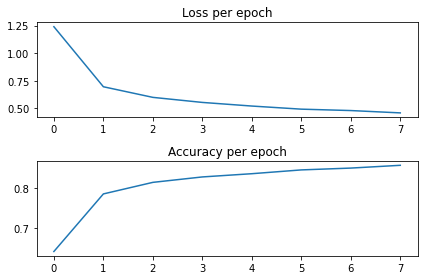

In [8]:
#? plot training information
fig, axs = plt.subplots(2)

axs[0].plot(history.history['loss'])
axs[0].set_title('Loss per epoch')
axs[1].plot(history.history['accuracy'])
axs[1].set_title('Accuracy per epoch')

fig.tight_layout()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


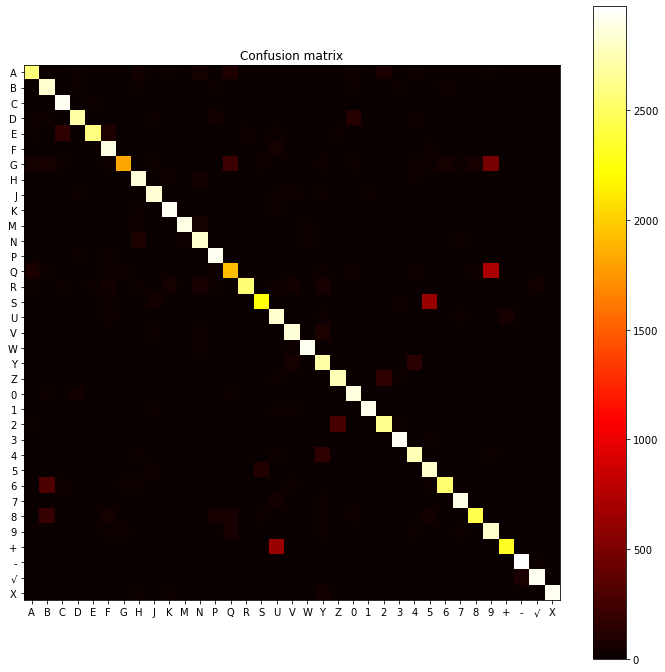

In [9]:
#? plot confusion matrix (Loosly following code from https://colab.research.google.com/drive/161SaEMssCa8vQUZQjIsIynjVqBsKzG7P)
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):

    # show the figure
    plt.figure(figsize=(12, 12))
    plt.imshow(cm, cmap='hot', interpolation='nearest')
    plt.colorbar()

    # set the tick marks to display the classifications
    plt.xticks(range(len(classes)), classes)
    plt.yticks(range(len(classes)), classes)

    # setup the title and display type
    plt.title(title)

    plt.show()

p_test = model.predict(Xs).argmax(axis=1)
cm = confusion_matrix(ys_indices, p_test)
classes = list(label_dictionary.values())

plot_confusion_matrix(cm, classes)

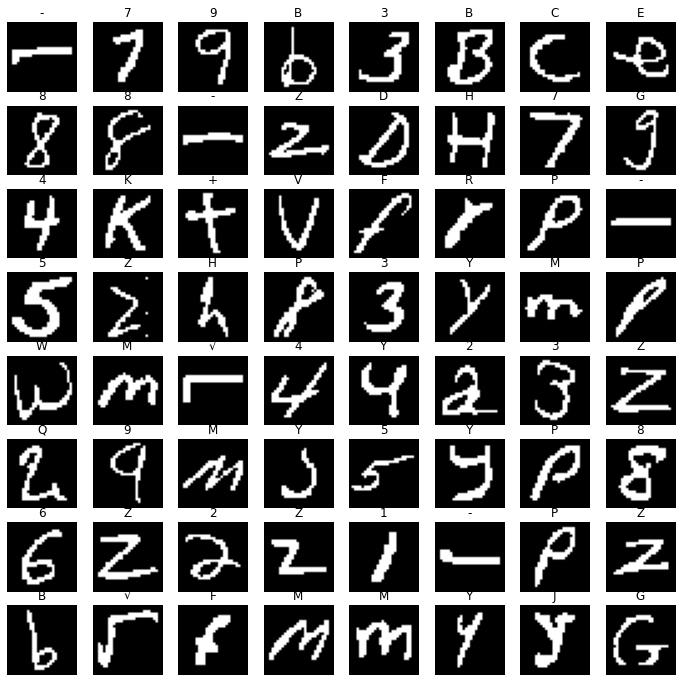

In [10]:
# plot out 64 images alongsize the model's prediction

fig = plt.figure(figsize=(12, 12))

for i in range(64):

    img = Xs[random.randint(0, Xs.shape[0])].reshape((28, 28))
    prediction = model.predict(img.reshape(1, 28, 28, 1))

    fig.add_subplot(8, 8, i+1)
    plt.axis('off')
    plt.title(label_dictionary[prediction.argmax()])
    plt.imshow(img, 'gray')

In [11]:
#? save the model for future use
model.save('./models/ocr_model_augmented_optimized')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ./models/ocr_model_augmented_optimized\assets
